# Final model training script:
Please run Combine_data_with_gold_price.ipynb to get the final processed and annotated data file.
'Final\adithya\Data\combined_dataset_with_price_change.csv'
before running this script.

### Import necessary libraries

In [ ]:
import pandas as pd
from torch.utils.data import DataLoader, random_split
import numpy as np
import torch
import torch.nn as nn
from tqdm import notebook as tqdm
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import shutil
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


In [2]:
#Import our defined classes and functions
from modules import NewsDataset, SetTransformer 
from functions import group_into_set

### Read the dataset.

In [3]:
# df = pd.read_csv("../Data/combined_dataset_with_price_change.csv",index_col=0)

# Load
df = pd.read_pickle('../Data/combined_dataset_with_price_change.pkl')
print("Number of rows in df:",df.shape)
df.head()

Number of rows in df: (6491, 6)


,Date,text,sentiment,topic_encodings,sentiment_combined_encodings,price_percentage_change
0,2016-01-28,"april gold down 20 cents to settle at $1,116.1...",-0.999000,"[-0.030607987, -0.06112092, 0.05298826, 0.0025...","[0.030577388, 0.061059814, -0.052935287, -0.00...",0.191615
1,2016-01-28,gold sticks near 12-week high as fed eyes glob...,0.996703,"[0.016134372, -0.030435134, 0.05567852, 0.0271...","[0.016081171, -0.03033478, 0.05549493, 0.02705...",0.191615
2,2016-01-28,the biggest potential driver for gold prices i...,0.005663,"[0.054409396, -0.09339435, -0.0011068282, 0.01...","[0.0003081177, -0.00052888755, -6.2679132e-06,...",0.191615
3,2016-01-28,"buy comex gold if it touches $1,107-08/ounce",0.002590,"[-0.00877056, -0.017302277, 0.08381294, -0.038...","[-2.2712242e-05, -4.4805973e-05, 0.00021704198...",0.191615
4,2016-01-28,gold prices down slightly in asia with fed rat...,-0.999000,"[0.007710825, -0.049220897, 0.0563185, 0.00629...","[-0.007703116, 0.04917169, -0.056262195, -0.00...",0.191615


### Initialize the dataloader and model

In [4]:
#Some settings
batch_size = 50
articles_per_day = 10

In [5]:
#Group input data into sets for use in model.
encodings, price_change = group_into_set(df,articles_per_day)

In [6]:
print(encodings.shape,price_change.shape)

(1648, 10, 512) (1648, 1)


In [7]:
dataset = NewsDataset(
        df.topic_encodings, 
        df.price_percentage_change
        )

# Calculate split sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# Split the dataset
train_dataset, test_dataset = random_split(
    dataset, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
model = SetTransformer(
    dim_input = 512, 
    num_outputs = 1, #One final prediction
    dim_output = 1, #1D output for price change
    num_inds=32, 
    dim_hidden=128, 
    num_heads=4, 
    ln=True #Layer normalization
    )

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [9]:
#Comment this cell if you don't have the package installed
from torchsummary import summary
print(summary(model,(1, 10, 512)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 32, 128]          16,512
            Linear-2              [-1, 10, 128]          65,664
            Linear-3              [-1, 10, 128]          65,664
         LayerNorm-4              [-1, 32, 128]             256
            Linear-5              [-1, 32, 128]          16,512
         LayerNorm-6              [-1, 32, 128]             256
               MAB-7              [-1, 32, 128]               0
            Linear-8              [-1, 10, 128]          65,664
            Linear-9              [-1, 32, 128]          16,512
           Linear-10              [-1, 32, 128]          16,512
        LayerNorm-11              [-1, 10, 128]             256
           Linear-12              [-1, 10, 128]          16,512
        LayerNorm-13              [-1, 10, 128]             256
              MAB-14              [-1, 

In [10]:
#Remove old runs data.
if os.path.exists('runs') and os.path.isdir('runs'):
    for item in os.listdir('runs'):
        item_path = os.path.join('runs', item)
        if os.path.isfile(item_path):
            os.remove(item_path)  # Remove file
        else:
            shutil.rmtree(item_path)  # Remove subdirectory

In [27]:
# Initialize TensorBoard writer
writer = SummaryWriter()

In [28]:
# After running this cell, visit http://localhost:6006 on your browser to visualize the training process.
%load_ext tensorboard 
# %reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [29]:
#Run this in your terminal separately to visualize the training process live
%tensorboard --logdir=runs --reload_interval=30 --host=127.0.0.1 #Autoreload every 30s

Reusing TensorBoard on port 6006 (pid 23352), started 0:32:36 ago. (Use '!kill 23352' to kill it.)

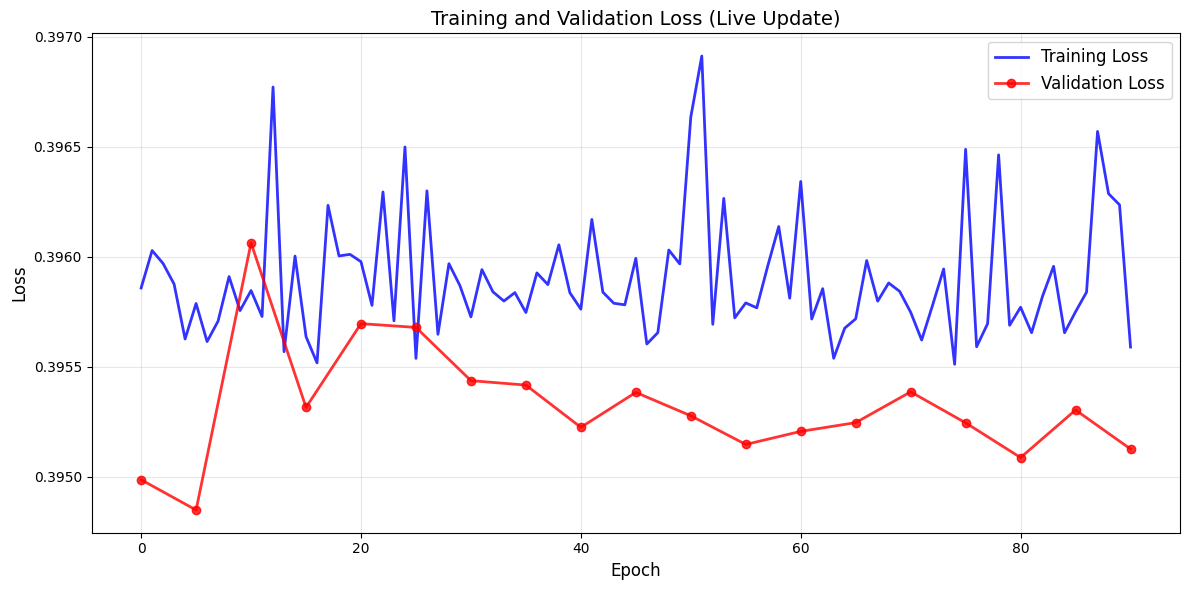

Training Progress: 100%|██████████| 100/100 [07:15<00:00,  4.36s/epoch, loss=0.3956, val_loss=0.3955]


In [33]:
plt.ioff()  # Turn off interactive mode initially
train_losses = []
val_losses = []
epochs_list = []
val_epochs_list = []

# Training loop
num_epochs = 100
pbar = tqdm.tqdm(range(num_epochs), desc="Training Progress", unit="epoch")

avg_loss = 0.0
avg_val_loss = 0.0

for epoch in pbar:
    model.train()
    losses = []
    
    for batch_idx, (inps, outs) in enumerate(train_loader):
        inps = inps.to(device)
        outs = outs.to(device)
        
        preds = model(inps)
        if preds.dim() > 1:
            preds = preds.squeeze()
        if outs.dim() > 1:
            outs = outs.squeeze()
        
        loss = criterion(preds, outs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    avg_loss = np.mean(losses)
    train_losses.append(avg_loss)
    epochs_list.append(epoch)
    
    writer.add_scalar('Loss/train', avg_loss, epoch)
    
    # Validation every 5 epochs
    if epoch % 5 == 0:
        model.eval()
        val_losses_temp = []
        
        with torch.no_grad():
            for inps, outs in test_loader:
                inps = inps.to(device)
                outs = outs.to(device)
                
                preds = model(inps)
                if preds.dim() > 1:
                    preds = preds.squeeze()
                if outs.dim() > 1:
                    outs = outs.squeeze()
                
                loss = criterion(preds, outs)
                val_losses_temp.append(loss.item())
        
        avg_val_loss = np.mean(val_losses_temp)
        val_losses.append(avg_val_loss)
        val_epochs_list.append(epoch)
        
        writer.add_scalar('Loss/validation', avg_val_loss, epoch)
    
    # Update plot every 10 epochs
    if epoch % 10 == 0:
        clear_output(wait=True)
        
        plt.figure(figsize=(12, 6))
        plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', alpha=0.8, linewidth=2)
        if val_losses:
            plt.plot(val_epochs_list, val_losses, 'r-', label='Validation Loss', 
                    alpha=0.8, marker='o', linewidth=2, markersize=6)
        
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title('Training and Validation Loss (Live Update)', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'val_loss': f'{avg_val_loss:.4f}'})

In [17]:
# Save the model checkpoint
final_checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'loss': avg_loss,
    'val_loss': avg_val_loss
}
torch.save(final_checkpoint, 'FinalModel/final_model.pth')

### Load model

In [19]:
#Load checkpoint file if exists.
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    val_loss = checkpoint['val_loss']
    return epoch, loss

# Load the model from the checkpoint
checkpoint_path = 'FinalModel/final_model.pth'
if os.path.exists(checkpoint_path):
    start_epoch, start_loss = load_checkpoint(checkpoint_path)
    print(f"Model loaded from {checkpoint_path} at epoch {start_epoch} with loss {start_loss:.4f}")
else:
    start_epoch, start_loss = 0, float('inf')
    print(f"No checkpoint found at {checkpoint_path}. Starting from scratch.")

Model loaded from FinalModel/final_model.pth at epoch 100 with loss 0.3959
